In [15]:
import numpy as np
import pandas as pd
import tensorflow as tf
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import ADASYN
from sklearn.feature_selection import SelectKBest, mutual_info_classif
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1_l2
from sklearn.ensemble import RandomForestClassifier
from scipy import stats
from tensorflow.keras.layers import Dense, GRU, Dropout, BatchNormalization, Conv1D, Bidirectional
from tensorflow.keras.models import load_model
from typing import Dict, List, Optional, Tuple
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Optional, Tuple
from sklearn.metrics import classification_report, confusion_matrix
from scipy import stats
import warnings
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, BatchNormalization, Activation, SpatialDropout1D, Add,
    GRU, Concatenate, GlobalAveragePooling1D, GlobalMaxPooling1D, Dense,
    Dropout, LayerNormalization
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
)
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import MultiHeadAttention
import tensorflow as tf
import xgboost as xgb
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight


seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [16]:
class NetworkTrafficPipeline:
    def __init__(self):
        self.preprocessor = None
        self.model = None
        self.path = None
        
    def download_dataset(self):
        """Download dataset using kagglehub."""
        self.path = kagglehub.dataset_download("dhoogla/unswnb15")
        print("Dataset downloaded to:", self.path)
        return self.path
    
    def load_data(self):
        """Load training and testing datasets."""
        train_data = pd.read_parquet(f"{self.path}/UNSW_NB15_training-set.parquet")
        test_data = pd.read_parquet(f"{self.path}/UNSW_NB15_testing-set.parquet")
        return train_data, test_data

In [20]:
from typing import Dict, List, Tuple
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTENC, SMOTE
from collections import Counter
class UNSWPreprocessor:
    def __init__(self, data: pd.DataFrame, test_data: pd.DataFrame, val_size: float = 0.2):
        self.data = data.copy()
        self.test_data = test_data.copy()
        self.val_size = val_size
        self.scalers = {
            'robust': RobustScaler(),
            'standard': StandardScaler()
        }
        self.label_encoder: Dict[str, LabelEncoder] = {}
        self.categorical_columns = ['proto', 'service', 'state']
        self.selected_features = None
        self.feature_selector = None
        self.merge_threshold = 0.05
        self.merged_classes_mapping = None
        self.bounds = {}
        
        # Correlation analysis thresholds
        self.high_corr_threshold = 0.9
        self.correlation_pairs = [
            ('sbytes', 'spkts'), ('sbytes', 'sloss'), 
            ('dbytes', 'dpkts'), ('dbytes', 'dloss'),
            ('dwin', 'swin'), ('synack', 'tcprtt'),
            ('ct_dst_sport_ltm', 'ct_src_dport_ltm')
        ]
        
        # Important features based on correlation with target
        self.important_features = [
            'dload', 'ct_dst_sport_ltm', 'dmean', 'rate',
            'ct_src_dport_ltm', 'is_sm_ips_ports'
        ]

    def handle_unknown_labels(self, data: pd.DataFrame, col: str) -> np.ndarray:
        """
        Handles unknown labels by assigning them a default value (-1)
        """
        encoded_column = []
        for value in data[col]:
            if value in self.label_encoder[col].classes_:
                encoded_column.append(self.label_encoder[col].transform([value])[0])
            else:
                encoded_column.append(-1)
        return np.array(encoded_column)

    def split_train_val(self, X: pd.DataFrame, y: pd.Series) -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
        return train_test_split(
            X, y,
            test_size=self.val_size,
            stratify=y,
            random_state=42
        )

    def add_engineered_features(self, data: pd.DataFrame) -> pd.DataFrame:
        eps = 1e-8
        
        # Basic rate and ratio features
        data['bytes_per_packet'] = (data['sbytes'] + data['dbytes']) / (data['spkts'] + data['dpkts'] + eps)
        data['bytes_ratio'] = np.log1p(data['sbytes']) - np.log1p(data['dbytes'])
        data['packets_ratio'] = np.log1p(data['spkts']) - np.log1p(data['dpkts'])
        data['packet_rate'] = (data['spkts'] + data['dpkts']) / (data['dur'] + eps)
        data['byte_rate'] = (data['sbytes'] + data['dbytes']) / (data['dur'] + eps)
        
        # Source and destination specific features
        data['srate'] = data['spkts'] / (data['dur'] + eps)
        data['drate'] = data['dpkts'] / (data['dur'] + eps)
        data['sload'] = (data['sbytes'] * data['srate']) / (eps + data['dur'])
        data['dload'] = (data['dbytes'] * data['drate']) / (eps + data['dur'])
        
        # Loss-based features
        data['total_loss_ratio'] = (data['sloss'] + data['dloss']) / (data['spkts'] + data['dpkts'] + eps)
        data['loss_ratio_diff'] = (data['sloss'] / (data['spkts'] + eps)) - (data['dloss'] / (data['dpkts'] + eps))
        
        # Connection-based features
        if 'ct_state_ttl' in data.columns:
            data['conn_ratio'] = data['ct_src_dport_ltm'] / (data['ct_dst_sport_ltm'] + eps)
            data['state_ratio'] = data['ct_state_ttl'] / (data['ct_dst_ltm'] + eps)
            data['ct_dst_src_ratio'] = data['ct_dst_ltm'] / (data['ct_src_dport_ltm'] + eps)
        
        # Statistical features
        data['mean_diff'] = data['smean'] - data['dmean']
        data['jitter_ratio'] = np.log1p(data['sjit']) - np.log1p(data['djit'])
        
        # Complexity features
        if 'swin' in data.columns and 'dwin' in data.columns:
            data['protocol_complexity'] = data['swin'] * data['dwin']
        if 'tcprtt' in data.columns and 'synack' in data.columns:
            data['tcp_behaviour'] = (data['tcprtt'] * data['synack']) / (data['dur'] + eps)
        
        return data

    def handle_outliers(self, data: pd.DataFrame, columns: List[str], is_test: bool = False) -> pd.DataFrame:
        data_clean = data.copy()
        iqr_factor = 2.0 if is_test else 1.5
        
        for column in columns:
            Q1 = self.bounds[column]['Q1']
            Q3 = self.bounds[column]['Q3']
            IQR = Q3 - Q1
            lower_bound = Q1 - iqr_factor * IQR
            upper_bound = Q3 + iqr_factor * IQR
            
            if is_test:
                lower_bound = min(lower_bound, data_clean[column].min())
                upper_bound = max(upper_bound, data_clean[column].max())
            
            data_clean[column] = data_clean[column].clip(lower_bound, upper_bound)
            
        return data_clean

    def create_class_mapping(self, y: pd.Series) -> Dict[str, str]:
        class_counts = y.value_counts(normalize=True)
        classes_to_merge = class_counts[class_counts < self.merge_threshold].index
        return {cls: 'other_attack' for cls in classes_to_merge}

    def merge_minority_classes(self, y: pd.Series) -> pd.Series:
        if self.merged_classes_mapping is None:
            self.merged_classes_mapping = self.create_class_mapping(y)
        return y.replace(self.merged_classes_mapping)

    def balance_classes(self, X: pd.DataFrame, y: pd.Series, max_oversampling_ratio: float = 1.5) -> Tuple[pd.DataFrame, pd.Series]:
        """
        Balance classes using a combination of undersampling and controlled oversampling.
        Automatically switches between SMOTE and SMOTENC based on feature types.
        
        Parameters:
        -----------
        X : pd.DataFrame
            Features.
        y : pd.Series
            Target labels.
        max_oversampling_ratio : float, optional
            Maximum ratio of oversampling for minority classes. Default is 1.5.
        
        Returns:
        --------
        Tuple[pd.DataFrame, pd.Series]
            Balanced features and target labels.
        """
        # 1. Undersampling with Tomek Links to remove majority class noise
        tl = TomekLinks(sampling_strategy='majority')
        X_cleaned, y_cleaned = tl.fit_resample(X, y)
        
        # 2. Check if we have any categorical features left after feature selection
        categorical_features = [X.columns.get_loc(col) for col in self.categorical_columns 
                              if col in X.columns]
        
        # 3. Calculate class distribution after undersampling
        class_counts = Counter(y_cleaned)
        majority_class_count = max(class_counts.values())
        
        # 4. Define a controlled oversampling strategy
        sampling_strategy = {}
        for cls, count in class_counts.items():
            if count < majority_class_count:
                # Limit oversampling to avoid excessive balance
                sampling_strategy[cls] = min(int(count * max_oversampling_ratio), majority_class_count)
        
        # 5. Apply oversampling
        if categorical_features:
            # Use SMOTENC if we have categorical features
            smote = SMOTENC(
                categorical_features=categorical_features, 
                sampling_strategy=sampling_strategy,
                random_state=42
            )
        else:
            # Use regular SMOTE if we only have numerical features
            smote = SMOTE(
                sampling_strategy=sampling_strategy,
                random_state=42
            )
        
        X_balanced, y_balanced = smote.fit_resample(X_cleaned, y_cleaned)
        
        # 6. Log the class distribution after balancing
        print("Class distribution after balancing:", Counter(y_balanced))
        
        return X_balanced, y_balanced

    def select_features(self, X: pd.DataFrame, y: pd.Series, n_features: int = None) -> pd.DataFrame:
        """
        Select features while ensuring categorical features are preserved if needed.
        """
        if self.feature_selector is None:
            # Ensure we keep at least one categorical feature for SMOTENC
            categorical_cols_to_keep = [col for col in self.categorical_columns if col in X.columns]
            
            # Dynamic feature selection based on data dimensionality
            if n_features is None:
                n_features = min(int(np.sqrt(len(X.columns)) * 2), len(X.columns))
                # Ensure we have space for categorical features
                n_features = max(n_features, len(categorical_cols_to_keep))
            
            # Remove highly correlated features
            features_to_drop = []
            corr_matrix = X.corr().abs()
            
            for pair in self.correlation_pairs:
                if pair[0] in X.columns and pair[1] in X.columns:
                    if corr_matrix.loc[pair[0], pair[1]] > self.high_corr_threshold:
                        # Don't drop if it's a categorical feature we want to keep
                        if pair[0] not in categorical_cols_to_keep and pair[0] not in self.important_features:
                            features_to_drop.append(pair[0])
                        elif pair[1] not in categorical_cols_to_keep:
                            features_to_drop.append(pair[1])
            
            X = X.drop(columns=features_to_drop)
            
            # Sample for large datasets
            if len(X) > 50000:
                X_sample = X.sample(n=50000, random_state=42)
                y_sample = y[X_sample.index]
            else:
                X_sample, y_sample = X, y
            
            # Select features while preserving categorical columns
            non_categorical_cols = [col for col in X.columns if col not in categorical_cols_to_keep]
            n_features_to_select = n_features - len(categorical_cols_to_keep)
            
            if n_features_to_select > 0 and non_categorical_cols:
                self.feature_selector = SelectKBest(
                    score_func=lambda X, y: mutual_info_classif(X, y, n_jobs=-1),
                    k=n_features_to_select
                )
                # Fit only on non-categorical features
                X_non_cat = X_sample[non_categorical_cols]
                self.feature_selector.fit(X_non_cat, y_sample)
                
                # Get selected features
                selected_non_cat = X_non_cat.columns[self.feature_selector.get_support()].tolist()
                self.selected_features = categorical_cols_to_keep + selected_non_cat
            else:
                self.selected_features = X.columns.tolist()
            
        return X[self.selected_features]

    def preprocess_data(self) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.Series, pd.Series, pd.Series]:
        # Remove redundant or low variance columns
        columns_to_drop = ['swin', 'stcpb', 'dtcpb', 'dwin', 'is_sm_ips_ports', 
                          'ct_flw_http_mthd', 'label']
        
        for df in [self.data, self.test_data]:
            df.drop(columns=[col for col in columns_to_drop if col in df.columns], 
                   inplace=True)
            df = self.add_engineered_features(df)
        
        # Handle categorical features
        for col in self.categorical_columns:
            if col in self.data.columns:
                self.label_encoder[col] = LabelEncoder()
                self.data[col] = self.label_encoder[col].fit_transform(self.data[col])
                if col in self.test_data.columns:
                    self.test_data[col] = self.handle_unknown_labels(self.test_data, col)
        
        X = self.data.drop(['attack_cat'], axis=1)
        y = self.data['attack_cat']
        X_test = self.test_data.drop(['attack_cat'], axis=1)
        y_test = self.test_data['attack_cat']
        
        # Calculate bounds for outlier handling
        numerical_columns = X.select_dtypes(include=['float64', 'int64']).columns
        for column in numerical_columns:
            Q1 = X[column].quantile(0.25)
            Q3 = X[column].quantile(0.75)
            self.bounds[column] = {'Q1': Q1, 'Q3': Q3}
        
        # Handle outliers
        X = self.handle_outliers(X, numerical_columns)
        X_test = self.handle_outliers(X_test, numerical_columns, is_test=True)
        
        # Process target variable
        y = self.merge_minority_classes(y)
        y_test = self.merge_minority_classes(y_test)
        self.label_encoder['attack_cat'] = LabelEncoder()
        y = pd.Series(self.label_encoder['attack_cat'].fit_transform(y), index=y.index)
        y_test = self.handle_unknown_labels(pd.DataFrame({'attack_cat': y_test}), 'attack_cat')
        
        # Split data
        X_train, X_val, y_train, y_val = self.split_train_val(X, y)
        
        # Select features
        X_train = self.select_features(X_train, y_train)
        X_val = X_val[self.selected_features]
        X_test = X_test[self.selected_features]
        
        # Scale features
        for scaler_name, scaler in self.scalers.items():
            if scaler_name == 'robust':
                cols_to_scale = [col for col in X_train.columns if col not in self.categorical_columns]
            else:  # standard scaler for important features
                cols_to_scale = [col for col in X_train.columns if col in self.important_features]
            
            if cols_to_scale:
                X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
                X_val[cols_to_scale] = scaler.transform(X_val[cols_to_scale])
                X_test[cols_to_scale] = scaler.transform(X_test[cols_to_scale])
        
        # Balance classes
        X_train_balanced, y_train_balanced = self.balance_classes(X_train, y_train)
        
        return X_train_balanced, X_val, X_test, y_train_balanced, y_val, y_test

In [21]:
# Initialize pipeline
pipeline = NetworkTrafficPipeline()
    
# Download and load data
path = pipeline.download_dataset()
train_data, test_data = pipeline.load_data()

Dataset downloaded to: C:\Users\Administrator\.cache\kagglehub\datasets\dhoogla\unswnb15\versions\5


In [22]:
preprocessor = UNSWPreprocessor(train_data, test_data, val_size=0.2)
X_train, X_val, X_test, y_train, y_val, y_test = preprocessor.preprocess_data()

Class distribution after balancing: Counter({3: 42865, 4: 42865, 1: 40071, 2: 21820, 0: 14716, 5: 12589, 6: 6010})


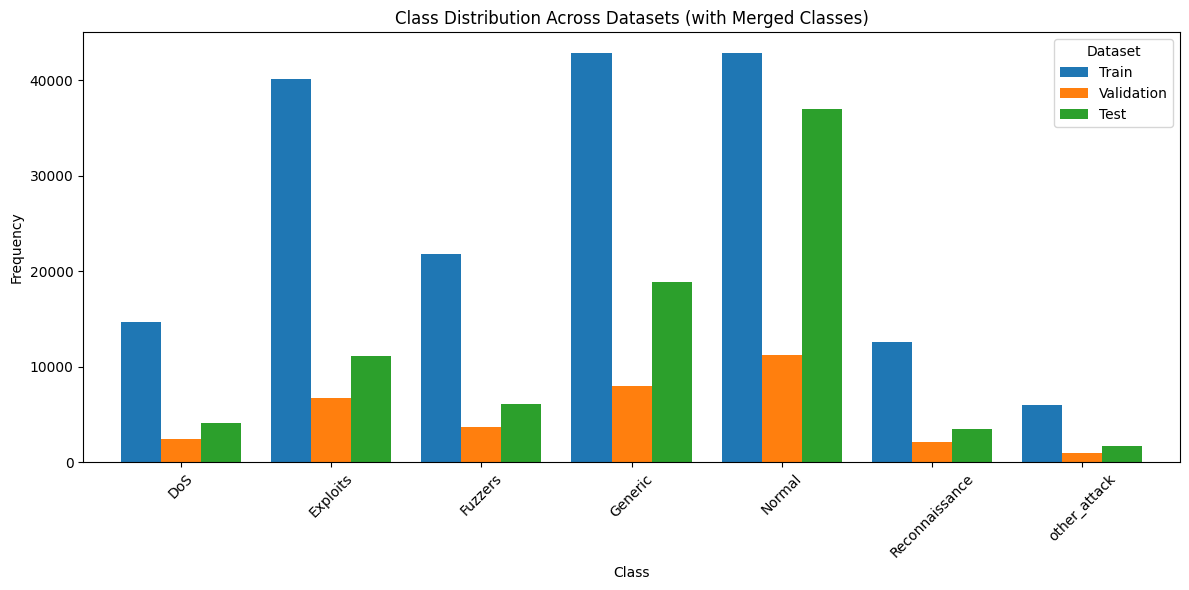

In [26]:
def plot_class_distribution_with_merge(y_train, y_val, y_test, label_encoder):
    # Mapear índices numéricos para rótulos das classes
    class_names = list(label_encoder['attack_cat'].classes_)
    
    # Frequências das classes
    train_counts = pd.Series(y_train).value_counts().sort_index()
    val_counts = pd.Series(y_val).value_counts().sort_index()
    test_counts = pd.Series(y_test).value_counts().sort_index()

    # Criar dataframe para facilitar o plot
    class_distribution = pd.DataFrame({
        'Class': class_names,  # Os nomes das classes devem corresponder aos índices
        'Train': train_counts.reindex(range(len(class_names)), fill_value=0),
        'Validation': val_counts.reindex(range(len(class_names)), fill_value=0),
        'Test': test_counts.reindex(range(len(class_names)), fill_value=0),
    }).set_index('Class')  # Preencher valores ausentes com zero

    # Plotar distribuição
    class_distribution.plot(kind='bar', figsize=(12, 6), width=0.8)
    plt.title('Class Distribution Across Datasets (with Merged Classes)')
    plt.ylabel('Frequency')
    plt.xlabel('Class')
    plt.xticks(rotation=45)
    plt.legend(title="Dataset")
    plt.tight_layout()
    plt.show()

# Chamar a função para plotar
plot_class_distribution_with_merge(y_train, y_val, y_test, preprocessor.label_encoder)


In [23]:
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, Concatenate, SpatialDropout1D, Add, GRU, GlobalAveragePooling1D, GlobalMaxPooling1D, Dense, Dropout, LayerNormalization, MultiHeadAttention
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import numpy as np
import pandas as pd
import tensorflow as tf

class EnhancedDeepModel:
    def __init__(self, input_shape, num_classes, sequence_length=10):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.sequence_length = sequence_length
        self.deep_model = None
        
    def _create_deep_model(self):
        base_filters = 64
        inputs = Input(shape=(self.sequence_length, self.input_shape))
        
        # 1. Enhanced Feature Extraction Block
        x = self._create_residual_block(inputs, base_filters)
        
        # 2. Advanced Temporal Pattern Block
        temporal = self._create_temporal_block(x, base_filters)
        
        # 3. Enhanced Multi-Scale Feature Block
        multi_scale = self._create_multi_scale_block(temporal, base_filters)
        
        # 4. Improved Self-Attention Block with relative positional encoding
        attention = self._create_attention_block(multi_scale, base_filters)
        
        # 5. Feature Aggregation with skip connections
        pooled = self._create_aggregation_block(attention, temporal, base_filters)
        
        # 6. Enhanced Classification Block with label smoothing
        outputs = self._create_classification_block(pooled)
        
        return Model(inputs=inputs, outputs=outputs)
    
    def _create_residual_block(self, x, filters):
        shortcut = x
        
        # Dual path convolution block
        path1 = Conv1D(filters//2, 3, padding='same')(x)
        path1 = BatchNormalization()(path1)
        path1 = Activation('swish')(path1)
        
        path2 = Conv1D(filters//2, 5, padding='same')(x)
        path2 = BatchNormalization()(path2)
        path2 = Activation('swish')(path2)
        
        x = Concatenate()([path1, path2])
        x = SpatialDropout1D(0.3)(x)
        
        # Residual connection
        if x.shape[-1] != shortcut.shape[-1]:
            shortcut = Conv1D(filters, 1, padding='same')(shortcut)
        
        return Add()([x, shortcut])
    
    def _create_temporal_block(self, x, filters):
        # Bidirectional GRU with skip connections
        forward = GRU(filters//2, return_sequences=True, 
                     kernel_regularizer=l2(0.01))(x)
        backward = GRU(filters//2, return_sequences=True, 
                      kernel_regularizer=l2(0.01), 
                      go_backwards=True)(x)
        
        concat = Concatenate()([forward, backward])
        return Add()([concat, x])
    
    def _create_multi_scale_block(self, x, filters):
        scales = [1, 3, 5, 7]  # Mais escalas para capturar diferentes padrões
        convs = []
        
        for scale in scales:
            conv = Conv1D(filters//len(scales), scale, 
                         padding='same', 
                         kernel_regularizer=l2(0.01))(x)
            conv = BatchNormalization()(conv)
            conv = Activation('swish')(conv)
            convs.append(conv)
        
        return Concatenate()(convs)
    
    def _create_attention_block(self, x, filters):
        # Multi-head attention com relative positional encoding
        attention_heads = []
        num_heads = 8
        
        for _ in range(num_heads):
            attention_head = MultiHeadAttention(
                num_heads=1, 
                key_dim=filters//num_heads,
                kernel_regularizer=l2(0.01)
            )(x, x)
            attention_heads.append(attention_head)
        
        multi_head = Concatenate()(attention_heads)
        multi_head = Conv1D(filters, 1, padding='same')(multi_head)
        
        # Add & Norm
        x = Add()([multi_head, x])
        return LayerNormalization()(x)
    
    def _create_aggregation_block(self, attention, temporal, filters):
        # Global context pooling
        avg_pool = GlobalAveragePooling1D()(attention)
        max_pool = GlobalMaxPooling1D()(attention)
        
        # Temporal context
        temporal_context = GlobalAveragePooling1D()(temporal)
        
        return Concatenate()([avg_pool, max_pool, temporal_context])
    
    def _create_classification_block(self, x):
        x = Dense(256, activation='swish', kernel_regularizer=l2(0.02))(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        
        x = Dense(128, activation='swish', kernel_regularizer=l2(0.02))(x)
        x = BatchNormalization()(x)
        x = Dropout(0.3)(x)
        
        return Dense(self.num_classes, activation='softmax')(x)
    
    def prepare_sequence_data(self, X):
        """
        Prepara os dados em formato de sequência sem criar dimensões extras
        """
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()
        
        # Se os dados já estiverem no formato correto, retorna
        if len(X.shape) == 3 and X.shape[1] == self.sequence_length:
            return X
        
        # Garantir que X seja 2D
        if len(X.shape) == 1:
            X = X.reshape(-1, self.input_shape)
        
        n_samples = X.shape[0]
    
        # Criar uma matriz de zeros com o shape desejado
        sequences = np.zeros((n_samples, self.sequence_length, self.input_shape))
    
        # Para cada amostra, preencher a sequência
        for i in range(n_samples):
            # Calcular os índices de início e fim
            start_idx = max(0, i - self.sequence_length + 1)
            end_idx = i + 1
        
            # Pegar os dados reais disponíveis
            actual_seq = X[start_idx:end_idx]
        
            # Calcular quanto padding precisamos
            padding_needed = self.sequence_length - len(actual_seq)
        
            if padding_needed > 0:
                # Preencher o início com o primeiro valor
                sequences[i, :padding_needed] = actual_seq[0:1]  # Usar slicing para manter a dimensão
                # Preencher o resto com os valores reais
                sequences[i, padding_needed:] = actual_seq
            else:
                # Se tivermos dados suficientes, pegar os últimos sequence_length valores
                sequences[i] = actual_seq[-self.sequence_length:]
    
        print(f"Shape final das sequências: {sequences.shape}")
        return sequences
    
    def train(self, X_train, y_train, X_val, y_val):
        """
        Treina o modelo de deep learning
        """
        print("Criando e compilando o modelo deep learning...")
        self.deep_model = self._create_deep_model()
        
        print("Preparando dados de sequência...")
        X_train_seq = self.prepare_sequence_data(X_train)
        X_val_seq = self.prepare_sequence_data(X_val)
        
        print(f"Forma dos dados de treino: {X_train_seq.shape}")
        print(f"Forma dos dados de validação: {X_val_seq.shape}")
        
        # Treinar modelo deep learning
        print("Treinando modelo deep learning...")
        history = self._train_deep_model(X_train_seq, y_train, X_val_seq, y_val)
        
        return history
    
    def _train_deep_model(self, X_train, y_train, X_val, y_val):
        X_train_seq = self.prepare_sequence_data(X_train)
        X_val_seq = self.prepare_sequence_data(X_val)
        
        # 1. Calcular os pesos das classes
        class_weights = compute_class_weight(
            class_weight='balanced',  # Calcula pesos para balancear as classes
            classes=np.unique(y_train),  # Classes únicas
            y=y_train  # Rótulos de treino
        )
        class_weights = dict(enumerate(class_weights))  # Converter para dicionário
        print(f"Pesos das classes: {class_weights}")
        
        # 2. Learning rate schedule
        initial_learning_rate = 0.001
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate,
            decay_steps=1000,
            decay_rate=0.9
        )
        
        # 3. Callbacks
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=15, 
                         restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                             patience=7, min_lr=1e-6),
            ModelCheckpoint('best_deep_model.keras', 
                          save_best_only=True)
        ]
        
        # 4. Compilar o modelo
        self.deep_model.compile(
            optimizer=Adam(learning_rate=lr_schedule),
            loss='sparse_categorical_crossentropy',  # Para rótulos inteiros
            metrics=['accuracy']
        )
        
        # 5. Treinar o modelo com class weights
        history = self.deep_model.fit(
            X_train_seq, y_train,
            validation_data=(X_val_seq, y_val),
            batch_size=32,
            epochs=3,
            callbacks=callbacks,
            class_weight=class_weights  # Passar os pesos das classes
        )
        
        return history
    def predict(self, X):
        X_seq = self.prepare_sequence_data(X)
        return np.argmax(self.deep_model.predict(X_seq), axis=1)

In [24]:
# Exemplo de uso
model = EnhancedDeepModel(input_shape=X_train.shape[1],num_classes=len(np.unique(y_train)), sequence_length=20)
history = model.train(X_train, y_train, X_val, y_val)
predictions = model.predict(X_test)

Criando e compilando o modelo deep learning...
Preparando dados de sequência...
Shape final das sequências: (180936, 20, 12)
Shape final das sequências: (35069, 20, 12)
Forma dos dados de treino: (180936, 20, 12)
Forma dos dados de validação: (35069, 20, 12)
Treinando modelo deep learning...
Pesos das classes: {0: 1.7564555585757, 1: 0.6450550273264954, 2: 1.184601283226398, 3: 0.6030094482678175, 4: 0.6030094482678175, 5: 2.0532210660100088, 6: 4.300831946755408}
Epoch 1/3
5655/5655 ━━━━━━━━━━━━━━━━━━━━ 187s 29ms/step - accuracy: 0.5052 - loss: 3.5231 - val_accuracy: 0.2360 - val_loss: 4.2422 - learning_rate: 5.5111e-04
Epoch 2/3
5655/5655 ━━━━━━━━━━━━━━━━━━━━ 153s 27ms/step - accuracy: 0.6730 - loss: 1.1537 - val_accuracy: 0.3747 - val_loss: 2.2087 - learning_rate: 3.0373e-04
Epoch 3/3
5655/5655 ━━━━━━━━━━━━━━━━━━━━ 151s 27ms/step - accuracy: 0.7011 - loss: 1.0131 - val_accuracy: 0.5850 - val_loss: 1.1896 - learning_rate: 1.6739e-04
Shape final das sequências: (82332, 20, 12)
2573/25

In [25]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.25      0.40      0.31      4089
           1       0.22      0.42      0.29     11132
           2       0.18      0.50      0.26      6062
           3       1.00      0.89      0.94     18871
           4       0.77      0.33      0.46     37000
           5       0.19      0.03      0.06      3496
           6       0.07      0.17      0.09      1682

    accuracy                           0.47     82332
   macro avg       0.38      0.39      0.34     82332
weighted avg       0.64      0.47      0.50     82332



In [ ]:
pr